*This notebook is mainly a translation from MATLAB/Octave [scripts](https://github.com/ikostoski/esp32-i2s-slm/tree/master/math) by Ivan Kostoski to Python.*

The purpose of this notebook is to design IIR filters for A/C-weighting and for equalizing (flattenning) microphone frequency response.

Unlike Ivan, I'm not an DSP expert, but from what I understand designing an IIR filter to achieve desired frequency response might be tricky and there is no straightforward way to do it in general case. However you might use some mix of answers found on dsp.stackexchange.com plus ad-hoc heuristics for your specific case.

You'll notice that all filters here are converted to *SOS (Second Order Sections)* form. This is done in order to improve numerical stability. As all calculations on ESP32 are performed using single float (32 bit) precision, higher order filters might become numerically unstable. So if you have a filter of higher order you can convert it to a cascade of *SOS* using `scipy.signal.tf2sos`

Also keep in mind that all digital filters coefficients are calculated with respect to fixed sampling rate. Here **48kHz** is used, but if you have a different rate, you might need to re-run this notebook with `fs` set to your required value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import norm
from numpy import convolve, pi, logspace, log10, set_printoptions
from scipy.signal import freqz, butter, lfilter, sosfilt, freqs, bilinear, tf2sos, sos2tf, sosfreqz
from dsptools import invfreqz, polystab

set_printoptions(precision=20, floatmode='unique', linewidth=200)

%config InlineBackend.figure_format='retina'

In [2]:
fs = 48000
f = logspace(0, 5, 2048)
sos_coeff = [0, 1, 2, 4, 5]

## A-weighting

For A-weighting coefficents found in answer on [dsp.stackexchange.com](https://dsp.stackexchange.com/a/36122/65262) are used. So the only work required is to check that they produce correct results and convert them into SOS form. But note that they were designed for 48kHz. If you need a different sampling rate, you might need another way how to calculate them, for example look at how C-weighting coeffients are calculated below.

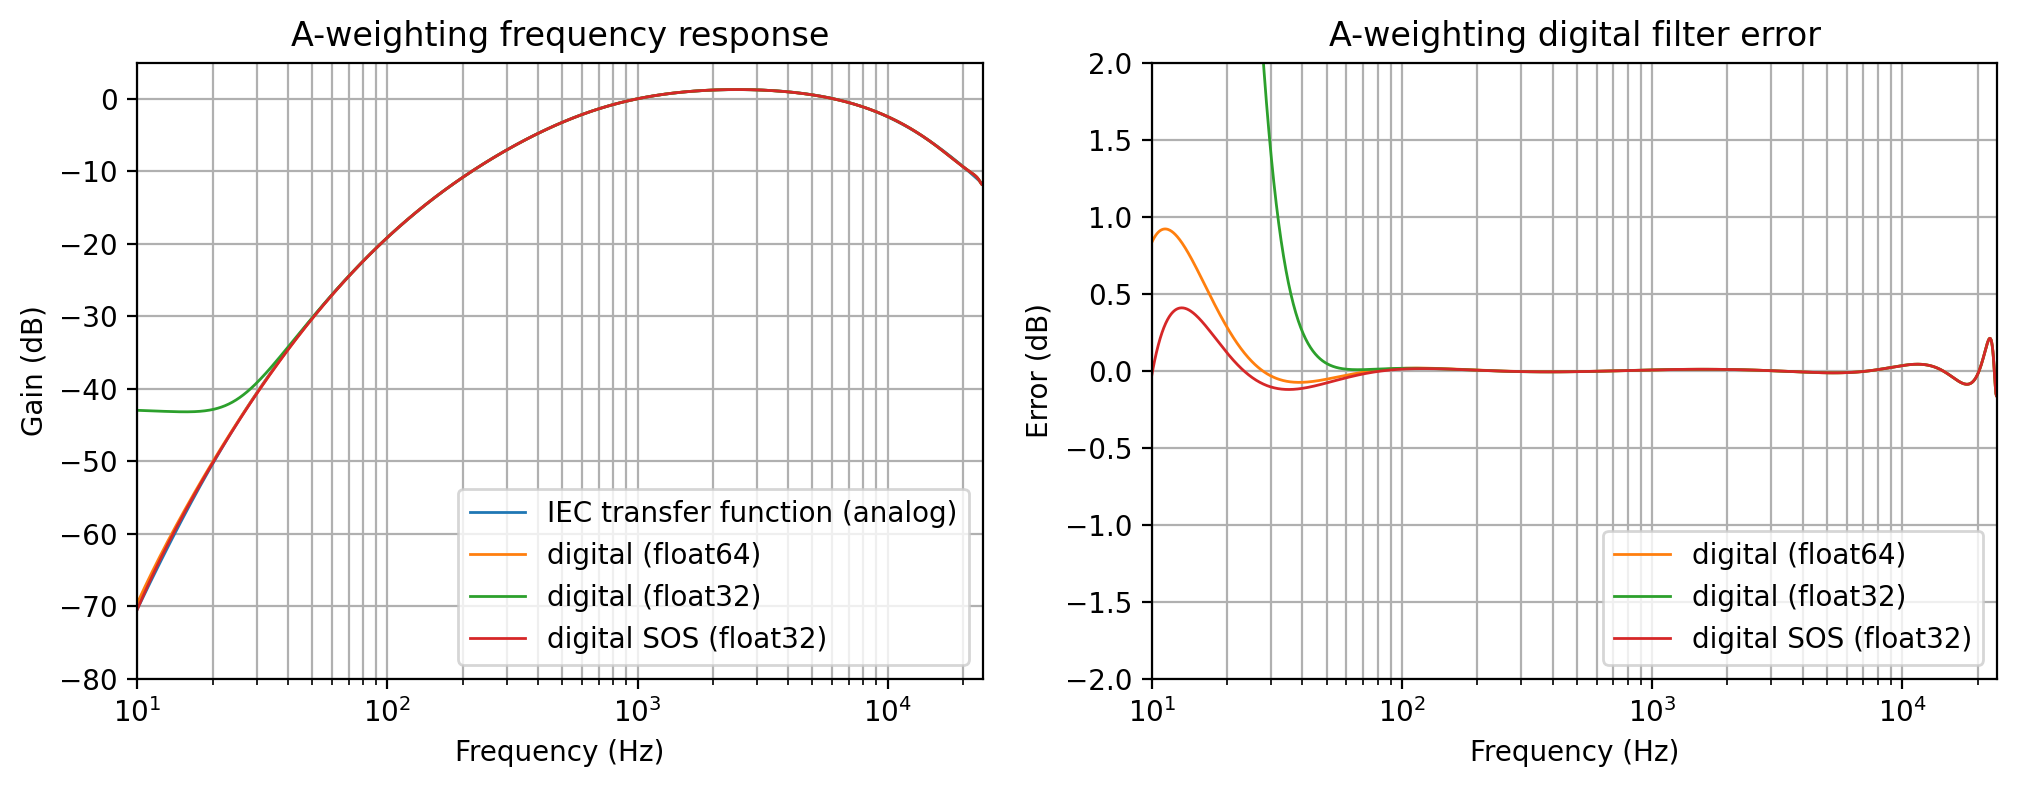

A-weighting SOS:
[[ 0.16999495   0.741029     0.52548885  -0.11321865  -0.056549273]
 [ 1.          -2.00027      1.0002706   -0.03433284  -0.79215795 ]
 [ 1.          -0.709303    -0.29071867  -1.9822421    0.9822986  ]]


In [3]:
# analog A-weighting filter according to IEC/CD 1672.
f1 = 20.598997
f2 = 107.65265
f3 = 737.86223
f4 = 12194.217
A1000 = 1.9997

B_a = [(2 * pi * f4)**2 * (10**(A1000 / 20.0)), 0., 0., 0., 0.]
A_a = convolve([1., +4 * pi * f4, (2 * pi * f4)**2], [1., +4 * pi * f1, (2 * pi * f1)**2])
A_a = convolve(convolve(A_a, [1., 2 * pi * f3]), [1., 2 * pi * f2])

# digital IIR filter coefficents from https://dsp.stackexchange.com/a/36122/65262
B_d = np.array([0.169994948147430, 0.280415310498794, -1.120574766348363, 0.131562559965936,
             0.974153561246036, -0.282740857326553, -0.152810756202003], dtype='float64')
A_d = np.array([1.0, -2.12979364760736134, 0.42996125885751674, 1.62132698199721426, -0.96669962900852902,
             0.00121015844426781, 0.04400300696788968], dtype='float64')

# convert digital filter to SOS for better numerical stability
sos = tf2sos(B_d, A_d).astype('float32')

_, H_a = freqs(B_a, A_a, f * (2 * np.pi))
_, H_d_f64 = freqz(B_d, A_d, f, fs=fs)
_, H_d_f32 = freqz(B_d.astype('float32'), A_d.astype('float32'), f, fs=fs)
_, H_d_sos_f32 = sosfreqz(sos, f, fs=fs)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].semilogx(f, 20 * log10(abs(H_a)), 'C0', lw=1, label='IEC transfer function (analog)')
ax[0].semilogx(f, 20 * log10(abs(H_d_f64)), 'C1', lw=1, label='digital (float64)')
ax[0].semilogx(f, 20 * log10(abs(H_d_f32)), 'C2', lw=1, label='digital (float32)')
ax[0].semilogx(f, 20 * log10(abs(H_d_sos_f32)), 'C3', lw=1, label='digital SOS (float32)')
ax[0].set_xlim(10, fs / 2)
ax[0].set_ylim(-80, 5)
ax[0].set_title('A-weighting frequency response')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Gain (dB)')
ax[0].grid(which='both')
ax[0].legend(loc='lower right')

ax[1].semilogx(f, 20 * log10(abs(H_d_f64)) - 20 * log10(abs(H_a)), 'C1', lw=1, label='digital (float64)')
ax[1].semilogx(f, 20 * log10(abs(H_d_f32)) - 20 * log10(abs(H_a)), 'C2', lw=1, label='digital (float32)')
ax[1].semilogx(f, 20 * log10(abs(H_d_sos_f32)) - 20 * log10(abs(H_a)), 'C3', lw=1, label='digital SOS (float32)')
ax[1].set_xlim(10, fs / 2)
ax[1].set_ylim(-2, 2)
ax[1].grid(which='both')
ax[1].set_title('A-weighting digital filter error')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Error (dB)')
ax[1].legend(loc='lower right')
plt.show()

print('A-weighting SOS:')
print(sos[:, sos_coeff])

From the charts above you can see why SOS form is used: if we convert high order (7th) filter coefficients to `float32` then we'll get quite large error at lower frequencies below 50Hz comparing to analog variant. However if we convert the filter to SOS then converting coefficients to `float32` wouldn't have such effect. In fact 32-bit SOS filter has even lower error than 64 bit high order filter.

## C-weighting
As there is no readily available C-weigthing coefficients on stackexchange, we could use here another approach by converting analog to digital with bilinear transform. However, as we'll see it might introduce quite large errors at high frequencies (closer to Nyquist), thus Ivan augments this method with curve fitting using `invfreqz` at high frequencies.

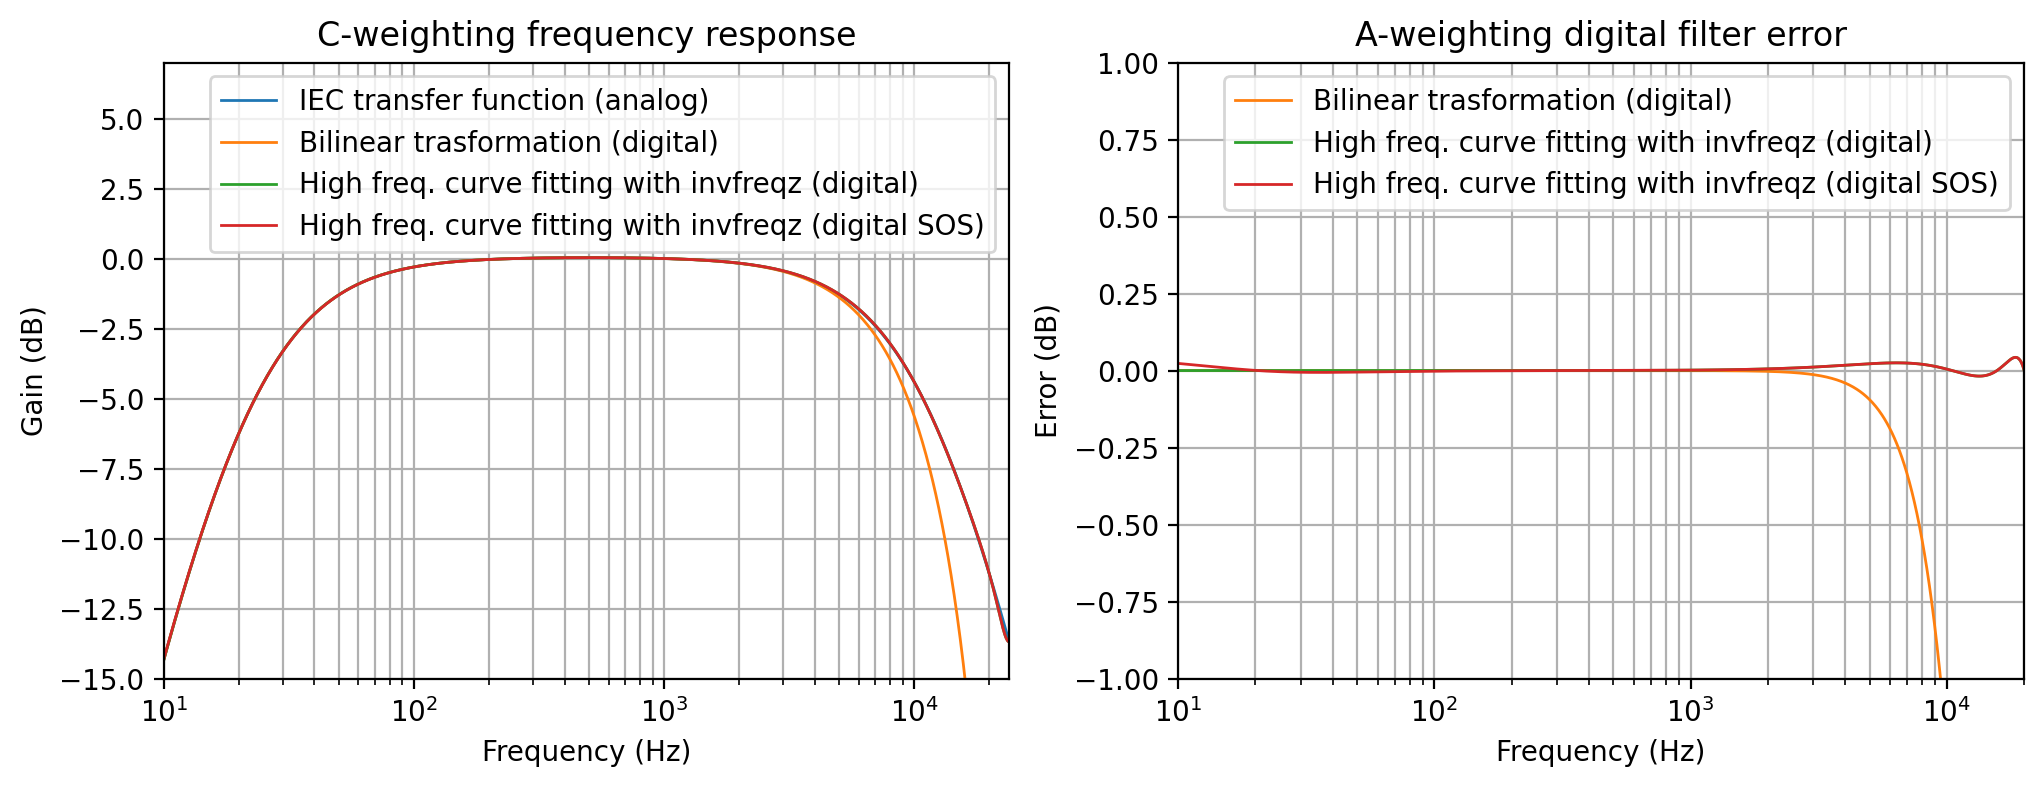

C-weighting SOS:
[[-0.49651518   -0.12296628   -0.0076134163 -0.37165618    0.03453208  ]
 [ 1.            1.3294908     0.44188643    1.2312505     0.37899444  ]
 [ 1.           -2.            1.           -1.9946145     0.9946217   ]]


In [4]:
# analog C-weighting filter according to IEC/CD 1672.
f1 = 20.598997
f4 = 12194.217
C1000 = 0.0619

B_a = [(2 * pi * f4) ** 2 * (10**(C1000 / 20)), 0, 0]
A_a = convolve([1, +4 * pi * f4, (2 * pi * f4) ** 2], [1, +4 * pi * f1, (2 * pi * f1) ** 2])

# Bilinear transformation of analog design to get the digital
B_d_bt, A_d_bt = bilinear(B_a, A_a, fs)
sos_bt = tf2sos(B_d_bt, A_d_bt)

# We will take the only the low frequency part of bilinear transformation
# Which was calculated to be approximately (second SOS):
sos_lo = sos_bt[1]

# Curve fitting of the 'high' frequency part with invfreqz
f_hi = np.array([1000, 1250, 10000, 16000, 20000, 24000])
_, h_hi = freqs(B_a, A_a, f_hi * 2 * pi)
w_hi = f_hi * ((2 * pi) / fs)
B_d_hi, A_d_hi = invfreqz(abs(h_hi), w_hi, 4, 4)
sos_hi = tf2sos(B_d_hi, A_d_hi)

# Merge SOS sections and reduce it a bit
sos = np.vstack((sos_lo, sos_hi))
sos[0, :3] *= 0.99785

# Convert to transfer function and try to stabilize
B_d_tf, A_d_tf = sos2tf(sos)
B_d_tf_s = polystab(B_d_tf) * norm(B_d_tf) / norm(polystab(B_d_tf))
A_d_tf_s = polystab(A_d_tf) * norm(A_d_tf) / norm(polystab(A_d_tf))
A_d_tf_s0 = A_d_tf_s[0]

# Calculate stable coefficients
B_d = B_d_tf_s / A_d_tf_s0
A_d = A_d_tf_s / A_d_tf_s0

sos = tf2sos(B_d, A_d).astype('float32')

# Compute frequency response of analog and digital filters
_, H_a = freqs(B_a, A_a, f * (2 * pi))
_, H_d_bt = freqz(B_d_bt, A_d_bt, f, fs=fs)
_, H_d = freqz(B_d, A_d, f, fs=fs)
_, H_sos = sosfreqz(sos, f, fs=fs)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].semilogx(f, 20 * log10(abs(H_a)), 'C0', lw=1, label='IEC transfer function (analog)')
ax[0].semilogx(f, 20 * log10(abs(H_d_bt)), 'C1', lw=1, label='Bilinear trasformation (digital)')
ax[0].semilogx(f, 20 * log10(abs(H_d)), 'C2', lw=1, label='High freq. curve fitting with invfreqz (digital)')
ax[0].semilogx(f, 20 * log10(abs(H_sos)), 'C3', lw=1, label='High freq. curve fitting with invfreqz (digital SOS)')
ax[0].set_xlim(10, fs / 2)
ax[0].set_ylim(-15, 7)
ax[0].set_title('C-weighting frequency response')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Gain (dB)')
ax[0].grid(True, which='both')
ax[0].legend()

ax[1].semilogx(f, 20 * np.log10(abs(H_d_bt)) - 20 * np.log10(abs(H_a)), 'C1', lw=1, label='Bilinear trasformation (digital)')
ax[1].semilogx(f, 20 * np.log10(abs(H_d)) - 20 * np.log10(abs(H_a)), 'C2', lw=1, label='High freq. curve fitting with invfreqz (digital)')
ax[1].semilogx(f, 20 * np.log10(abs(H_sos)) - 20 * np.log10(abs(H_a)), 'C3', lw=1, label='High freq. curve fitting with invfreqz (digital SOS)')
ax[1].set_xlim([10, 20000])
ax[1].set_ylim([-1, 1])
ax[1].set_title('A-weighting digital filter error')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Error (dB)')
ax[1].grid(True, which='both')
ax[1].legend()
plt.show()

print('C-weighting SOS:')
print(sos[:, sos_coeff])

## INMP441 equalization

According to its [datasheet](https://invensense.tdk.com/wp-content/uploads/2015/02/INMP441.pdf) INMP441 MEMS microphone has non-linear frequency response:

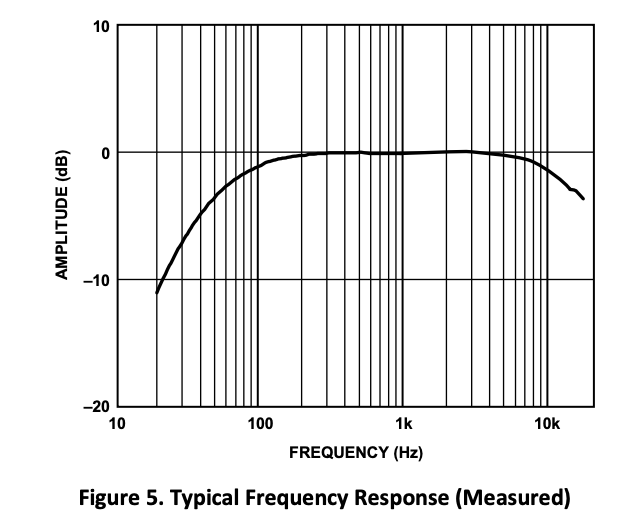

The idea proposed by Ivan is to build an IIR filter using `invfreqz` to match this chart and then inverse this filter by swapping A and B coefficients to get an equalizing filter, which when applied should in theory flatten the frequency response.

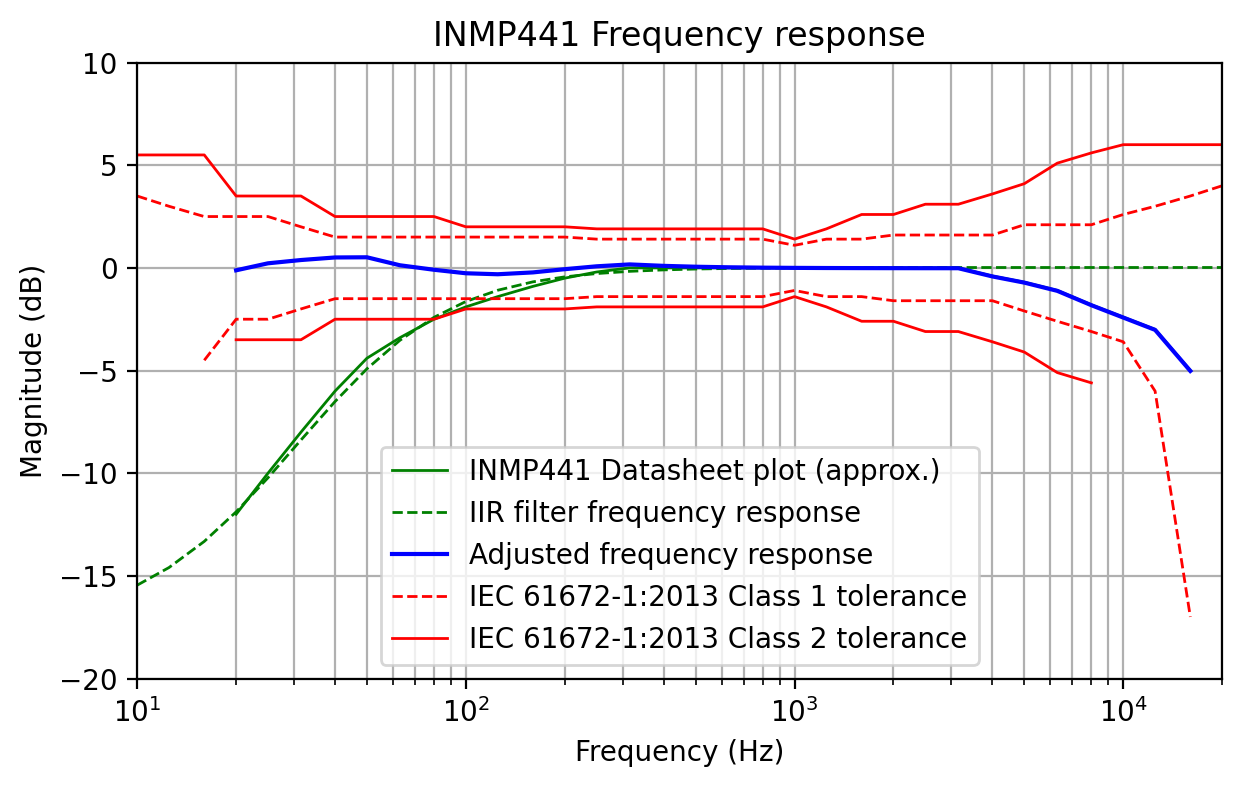

INMP441 equalizer SOS:
[[ 1.0019784  -1.9908513   0.9889158  -1.9951786   0.99518436]]


In [5]:
# IEC specified frequencies
iec_f = np.array([10, 12.5, 16, 20, 25, 31.5, 40, 50, 63, 80,
                  100, 125, 160, 200, 250, 315, 400, 500, 630, 800,
                  1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000,
                  10000, 12500, 16000, 20000])

# IEC Class 1 tolerances (top/bottom)
iec_c1_t_dB = [+3.5, +3.0, +2.5, +2.5, +2.5, +2.0, +1.5, +1.5, +1.5, +1.5,
               +1.5, +1.5, +1.5, +1.5, +1.4, +1.4, +1.4, +1.4, +1.4, +1.4,
               +1.1, +1.4, +1.4, +1.6, +1.6, +1.6, +1.6, +2.1, +2.1, +2.1,
               +2.6, +3.0, +3.5, +4.0]
iec_c1_b_dB = [-np.inf, -np.inf, -4.5, -2.5, -2.5, -2.0, -1.5, -1.5, -1.5, -1.5,
               -1.5, -1.5, -1.5, -1.5, -1.4, -1.4, -1.4, -1.4, -1.4, -1.4,
               -1.1, -1.4, -1.4, -1.6, -1.6, -1.6, -1.6, -2.1, -2.6, -3.1,
               -3.6, -6.0,  -17, -np.inf]

# IEC Class 2 tolerances (top/bottom)
iec_c2_t_dB = [+5.5, +5.5, +5.5, +3.5, +3.5, +3.5, +2.5, +2.5, +2.5, +2.5,
               +2.0, +2.0, +2.0, +2.0, +1.9, +1.9, +1.9, +1.9, +1.9, +1.9,
               +1.4, +1.9, +2.6, +2.6, +3.1, +3.1, +3.6, +4.1, +5.1, +5.6,
               +6.0, +6.0, +6.0, +6.0]
iec_c2_b_dB = [-np.inf, -np.inf, -np.inf, -3.5, -3.5, -3.5, -2.5, -2.5, -2.5, -2.5,
               -2.0, -2.0, -2.0, -2.0, -1.9, -1.9, -1.9, -1.9, -1.9, -1.9,
               -1.4, -1.9, -2.6, -2.6, -3.1, -3.1, -3.6, -4.1, -5.1, -5.6,
               -np.inf, -np.inf, -np.inf, -np.inf]

# Values visually estimated from INMP441 datasheet 'Typical Frequency Response' plot
ds_dB = np.array([-np.inf, -np.inf, -np.inf, -12, -10, -8, -6, -4.4, -3.4, -2.5,
                  -1.9, -1.4, -0.9, -0.5, -0.2, 0, 0, 0, 0, 0,
                  0, 0, 0, 0, 0, 0, -0.4, -0.7, -1.1, -1.8,
                  -2.4, -3.0, -5.0, -np.inf])

# These value are selected and adjusted for better curve fit
ds_l_f = np.array([20, 50, 100, 1000])
ds_l_dB = np.array([-13, -4.1, -1.8, 0])

# Low frequency filter design
# Convert Hz in rad/s and normalize for Fs
ds_l_w = ds_l_f * ((2 * pi) / fs)
# Convert plot decibels to magnitude
ds_l_mag = 10 ** (ds_l_dB / 20)

# Estimate coefficients
ds_l_B, ds_l_A = invfreqz(ds_l_mag, ds_l_w, 2, 2)
# Stabilize and normalize the filter
ds_A = polystab(ds_l_A) * norm(ds_l_A) / norm(polystab(ds_l_A))
ds_B = polystab(ds_l_B) * norm(ds_l_B) / norm(polystab(ds_l_B))
_, ds_H = freqz(ds_B, ds_A, iec_f, fs=fs)

# Equalizer filter, i.e. inverse from estimated transfer filter
# Swap A and B coefficients, and normalize to ds_B[0]
eq_B = ds_A / ds_B[0]
eq_A = ds_B / ds_B[0]
_, eq_H = freqz(eq_B, eq_A, iec_f, fs=fs)

plt.figure(figsize=(7, 4))
plt.semilogx(iec_f, ds_dB, 'g', lw=1, label='INMP441 Datasheet plot (approx.)')
plt.semilogx(iec_f, 20 * log10(abs(ds_H)), 'g--', lw=1, label='IIR filter frequency response')
plt.semilogx(iec_f, (ds_dB + 20 * log10(abs(eq_H))), 'b', label='Adjusted frequency response')
plt.semilogx(iec_f, iec_c1_t_dB, 'r--', label='IEC 61672-1:2013 Class 1 tolerance', lw=1)
plt.semilogx(iec_f, iec_c1_b_dB, 'r--', lw=1)
plt.semilogx(iec_f, iec_c2_t_dB, 'r', label='IEC 61672-1:2013 Class 2 tolerance', lw=1)
plt.semilogx(iec_f, iec_c2_b_dB, 'r', lw=1)
plt.title('INMP441 Frequency response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim([10, 20000])
plt.ylim([-20, 10])
plt.grid(which='both')
plt.legend()
plt.show()

sos = tf2sos(eq_B, eq_A).astype('float32')

print('INMP441 equalizer SOS:')
print(sos[:, sos_coeff])

Similarly you can develop filters for other microphones or find more of them in [Ivan's repository](https://github.com/ikostoski/esp32-i2s-slm/tree/master/math)